# <p style="background-color:#80ccff; font-family:newtimeroman; font-size:150%; text-align:center; border-radius:  80px 5px; padding-top:8px; padding-bottom:8px;">Import</p>

In [1]:
import pandas as pd
import numpy as np
import random

import glob

import cv2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import SeparableConv2D, BatchNormalization, Dropout, BatchNormalization, MaxPooling2D, Conv2D, Flatten, Dense, MaxPool2D
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# <p style="background-color:#80ccff; font-family:newtimeroman; font-size:150%; text-align:center; border-radius:  80px 5px; padding-top:8px; padding-bottom:8px;">Input</p>

In [2]:
train_path = glob.glob('../chest_xray/train/*/*')
test_path = glob.glob('../chest_xray/test/*/*')
val_path = glob.glob('../chest_xray/val/*/*')
val_path

['../chest_xray/val\\NORMAL\\NORMAL2-IM-1427-0001.jpeg',
 '../chest_xray/val\\NORMAL\\NORMAL2-IM-1430-0001.jpeg',
 '../chest_xray/val\\NORMAL\\NORMAL2-IM-1431-0001.jpeg',
 '../chest_xray/val\\NORMAL\\NORMAL2-IM-1436-0001.jpeg',
 '../chest_xray/val\\NORMAL\\NORMAL2-IM-1437-0001.jpeg',
 '../chest_xray/val\\NORMAL\\NORMAL2-IM-1438-0001.jpeg',
 '../chest_xray/val\\NORMAL\\NORMAL2-IM-1440-0001.jpeg',
 '../chest_xray/val\\NORMAL\\NORMAL2-IM-1442-0001.jpeg',
 '../chest_xray/val\\PNEUMONIA\\person1946_bacteria_4874.jpeg',
 '../chest_xray/val\\PNEUMONIA\\person1946_bacteria_4875.jpeg',
 '../chest_xray/val\\PNEUMONIA\\person1947_bacteria_4876.jpeg',
 '../chest_xray/val\\PNEUMONIA\\person1949_bacteria_4880.jpeg',
 '../chest_xray/val\\PNEUMONIA\\person1950_bacteria_4881.jpeg',
 '../chest_xray/val\\PNEUMONIA\\person1951_bacteria_4882.jpeg',
 '../chest_xray/val\\PNEUMONIA\\person1952_bacteria_4883.jpeg',
 '../chest_xray/val\\PNEUMONIA\\person1954_bacteria_4886.jpeg']

# <p style="background-color:#80ccff; font-family:newtimeroman; font-size:150%; text-align:center; border-radius:  80px 5px; padding-top:8px; padding-bottom:8px;">Preprocessing</p>

In [4]:
train, test = train_test_split(train_path, test_size=.2, shuffle=True)

print('Images for training:', len(train))
print('Images for validation:', len(test))

Images for training: 4172
Images for validation: 1044


In [5]:
normal = len([x for x in test_path if 'NORMAL' in x])
pneumonia = len([x for x in test_path if 'PNEUMONIA' in x])
pneumonia

390

Preparing the images

In [6]:
img_size = 180
def inp_process(file):
    data = []
    for f in file:
        try:
            part = f.split('/')
            if 'PNEUMONIA' in part[2]:
                label = 1
            else:
                label = 0                
            img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
            r_siz = cv2.resize(img, (img_size, img_size))
        except Exception as e:
            raise Exception(e)
        data.append([r_siz, label])
    return np.array(data)


def feature_label(data):
    x, y = [], []
    for feature, label in data:
        x.append(feature)
        y.append(label)
    return x, y

def prepara(data, x=True):
    if x == True:
        data = np.array(data)/255.
        data = data.reshape(-1,img_size,img_size, 1)
    else:
        np.array(data)
    return data

In [7]:
train = inp_process(train_path)
test = inp_process(test_path)
val = inp_process(val_path)

In [8]:
x_train, y_train = feature_label(train)
x_test, y_test = feature_label(test)
x_val, y_val = feature_label(val)

Label:  0


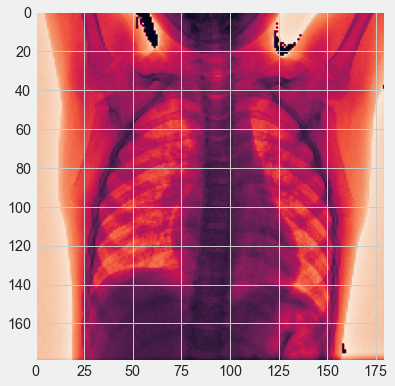

In [9]:
def test(index):
    current_image = x_train[index]
    label = y_train[index]
    print("Label: ", label)
    current_image = current_image.reshape((180, 180)) * 255
    plt.imshow(current_image)
    plt.show()
test(0)

In [10]:
x_train = prepara(x_train, True)
y_train = prepara(y_train, False)

x_test = prepara(x_test, True)
y_test = prepara(y_test, False)

x_val = prepara(x_val, True)
y_val = prepara(x_val, False)

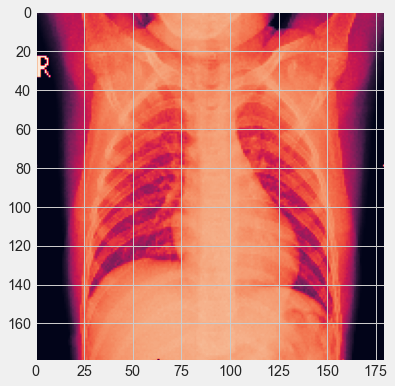

In [11]:
def test(index):
    current_image = x_val[index]
    current_image = current_image.reshape((180, 180)) * 255
    plt.imshow(current_image)
    plt.show()
    
    
test(0)

Normalization 

In [12]:
x_train = np.array(x_train) / 255.
x_val = np.array(x_val) / 255.
x_test = np.array(x_test) / 255.

In [13]:
len(x_train[0])

180

Placing the images in the same format

In [14]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)
len(x_train[0])

180

# <p style="background-color:#80ccff; font-family:newtimeroman; font-size:150%; text-align:center; border-radius:  80px 5px; padding-top:8px; padding-bottom:8px;">Model</p>

In [7]:
model = Sequential()
model.add(Conv2D(16, 3, activation='relu', padding='same',input_shape = (img_size,img_size,1)))
model.add(Conv2D(16, 3, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(SeparableConv2D(32, 3, activation='relu', padding='same'))
model.add(SeparableConv2D(32, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(SeparableConv2D(64, 3, activation='relu', padding='same'))
model.add(SeparableConv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())



model.add(Dropout(.2))

model.add(Flatten())


model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.3))

model.add(Dense(1, activation='sigmoid'))

In [16]:
weight_normal = len(x_train) / (2*normal)
weight_pneumonia = len(x_train) / (2*pneumonia)

class_weight = {0:weight_normal, 1:weight_pneumonia}

class_weight

{0: 11.145299145299145, 1: 6.687179487179487}

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
epochs = 30
batch_size = 100

stop = EarlyStopping(monitor='val_loss', patience=15, mode='min', verbose=1, restore_best_weights=True)
redutor = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [19]:
history_vanilla = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), class_weight=class_weight,
                            callbacks = [stop, redutor])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
53/53 [==============================] - 172s 3s/step - loss: 3.8819 - accuracy: 0.7457 - val_loss: 0.6647 - val_accuracy: 0.6250
Epoch 2/30
53/53 [==============================] - 152s 3s/step - loss: 1.3474 - accuracy: 0.9466 - val_loss: 0.6664 - val_accuracy: 0.6250
Epoch 3/30
53/53 [==============================] - 154s 3s/step - loss: 1.2141 - accuracy: 0.9452 - val_loss: 0.7538 - val_accuracy: 0.6250
Epoch 4/30
53/53 [==============================] - 152s 3s/step - loss: 0.9974 - accuracy: 0.9579 - val_loss: 0.8317 - val_accuracy: 0.6250

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/30
53/53 [==============================] - 152s 3s/step - loss: 0.9041 - accuracy: 0.9557 - val_loss: 1.0830 - val_accuracy: 0.6250
Epoch 6/30
53/53 [==============================] - 152s 3s/step - loss: 0.8

# <p style="background-color:#80ccff; font-family:newtimeroman; font-size:150%; text-align:center; border-radius:  80px 5px; padding-top:8px; padding-bottom:8px;">Result</p>

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 90, 90, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 90, 90, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 90, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0

Predicted : Normal
Label:Normal


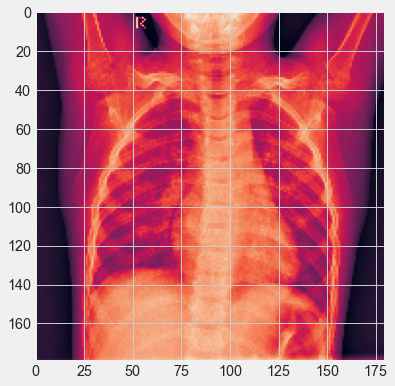

In [33]:

current_image = x_train[0]
result = model.predict(np.expand_dims(current_image, axis = 0))  
if result[0][0] >0.5:
  prediction = 'Pnuemonia'
else:
  prediction = 'Normal'  
print(f'Predicted : ' + prediction)



def test(index):
    current_image = x_train[index]
    label = y_train[index]
    if label==1:
        print("Label:pneumonia ")
    else:
        print("Label:Normal")
    current_image = current_image.reshape((180, 180)) * 255
    plt.imshow(current_image)
    plt.show()
test(0)

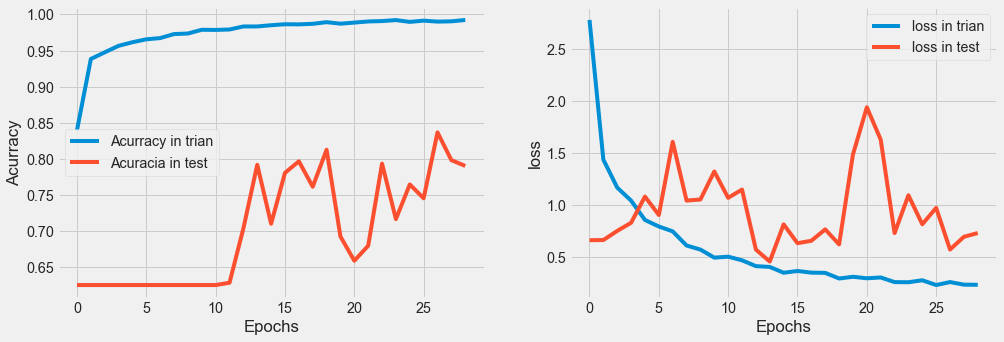

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(history_vanilla.history['accuracy'])
axes[0].plot(history_vanilla.history['val_accuracy'])
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Acurracy')
axes[0].legend(['Acurracy in trian','Acuracia in test'])
axes[0].grid(True)

axes[1].plot(history_vanilla.history['loss'])
axes[1].plot(history_vanilla.history['val_loss'])
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('loss')
axes[1].legend(['loss in trian','loss in test'])
axes[1].grid(True)